In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.cloud import bigtable

# Constants
PROJECT_ID = 'fa23-i535-judonato-project'
BIGTABLE_INSTANCE_ID = 'i5353-donato'
BIGTABLE_TABLE_ID = 'developing_nations_data'

# Initialize Bigtable client
client = bigtable.Client(project=PROJECT_ID, admin=True)
instance = client.instance(BIGTABLE_INSTANCE_ID)
table = instance.table(BIGTABLE_TABLE_ID)

In [3]:
def create_row_key(country_code, series_code, year):
    return f"{country_code}#{series_code}#{year}".encode()

### Query 1: Renewable Energy Consumption Trends

In [5]:
def renewable_energy_trends_df(table, country_codes, series_code, start_year, end_year):
    trend_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            row_key = create_row_key(country_code, series_code, year)
            row = table.read_row(row_key)
            if row:
                column_family = 'metrics'
                column_qualifier = f"{series_code}".encode()
                cell_value = row.cells[column_family].get(column_qualifier)
                
                # If there's a value, decode it, otherwise set it as 'N/A'
                if cell_value:
                    metric_value = cell_value[0].value.decode('utf-8')
                else:
                    metric_value = 'N/A'
                # Convert metric_value to a float if possible, otherwise set it to 0.0
                try:
                    if metric_value not in ["", "..", "N/A"]:  # Check for missing or placeholder values
                        metric_value = float(metric_value)
                    else:
                        metric_value = 0.0  # Default value for missing or unconvertible data
                except ValueError as e:
                    print(f"Error converting {metric_value} to float: {e}")  # Error handling
                    metric_value = 0.0

                trend_data.append({
                    'Country': country_code,
                    'Year': year,
                    'Renewable Energy Consumption': metric_value
                })
    
    # Convert the trend data into a pandas DataFrame
    df = pd.DataFrame(trend_data)
    
    return df

# Example usage
df = renewable_energy_trends_df(table, ['IND', 'BRA', 'ZAF', 'CHN', 'IDN'], 'EG.FEC.RNEW.ZS', 2012, 2022)
print(df.head())


  Country  Year  Renewable Energy Consumption
0     IND  2012                         34.75
1     IND  2013                         34.86
2     IND  2014                         33.85
3     IND  2015                         33.40
4     IND  2016                         33.01


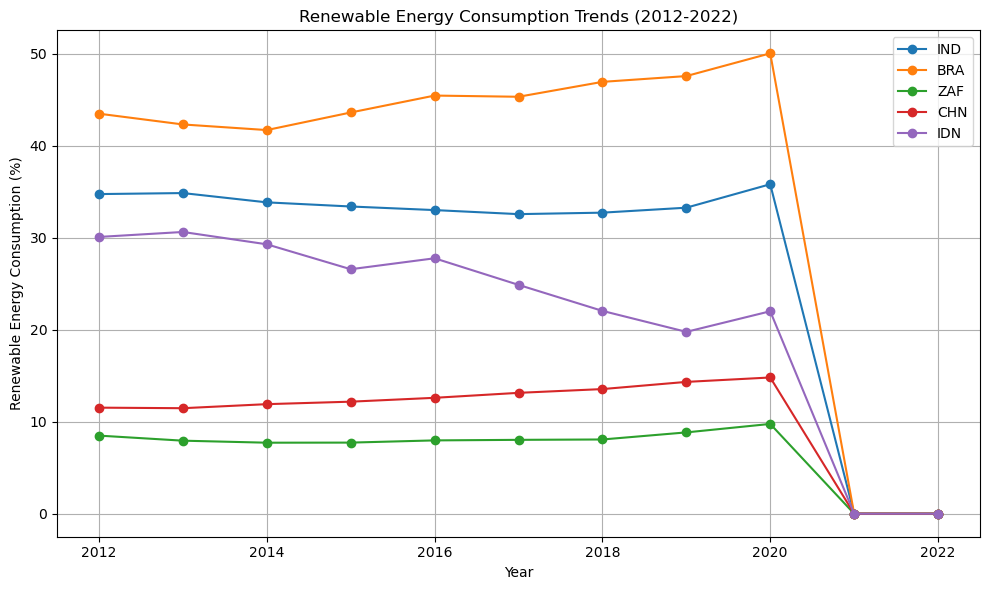

In [6]:
plt.figure(figsize=(10, 6))

# Plot for each country
for country in df['Country'].unique():
    country_df = df[df['Country'] == country]
    plt.plot(country_df['Year'], country_df['Renewable Energy Consumption'], marker='o', label=country)

plt.title('Renewable Energy Consumption Trends (2012-2022)')
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [16]:
# Helper function to get the metric value from a row
def get_metric_value(row, column_family, column_qualifier):
    cell_value = row.cells[column_family].get(column_qualifier.encode())
    # If there's a value, decode it, otherwise set it as 'N/A'
    if cell_value:
        metric_value = cell_value[0].value.decode('utf-8')
    else:
        metric_value = 'N/A'
    # Convert metric_value to a float if possible, otherwise set it to 0.0
    try:
        if metric_value not in ["", "..", "N/A"]:  # Check for missing or placeholder values
            metric_value = float(metric_value)
        else:
            metric_value = 0.0  # Default value for missing or unconvertible data
    except ValueError as e:
        print(f"Error converting {metric_value} to float: {e}")  # Error handling
        metric_value = 0.0
    return metric_value

### Query 2: Compare CO2 Emissions with Renewable Energy Consumption

In [17]:
def compare_co2_with_renewable_energy(table, country_codes, year):
    comparison_data = []
    for country_code in country_codes:
        co2_row_key = create_row_key(country_code, 'EN.ATM.CO2E.PC', year)
        renewable_row_key = create_row_key(country_code, 'EG.FEC.RNEW.ZS', year)
        co2_row = table.read_row(co2_row_key)
        renewable_row = table.read_row(renewable_row_key)
        if co2_row and renewable_row:
            co2_value = get_metric_value(co2_row, 'metrics', 'EN.ATM.CO2E.PC')
            renewable_value = get_metric_value(renewable_row, 'metrics', 'EG.FEC.RNEW.ZS')
            comparison_data.append({
                'Country': country_code,
                'Year': year,
                'CO2 Emissions': co2_value,
                'Renewable Energy Consumption': renewable_value
            })
    return pd.DataFrame(comparison_data)
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
print(compare_co2_with_renewable_energy(table, countries, 2020))

  Country  Year  CO2 Emissions  Renewable Energy Consumption
0     IND  2020       1.576093                         35.82
1     BRA  2020       1.942523                         50.05
2     ZAF  2020       6.687563                          9.76
3     CHN  2020       7.756138                         14.81
4     IDN  2020       2.071659                         22.01


In [18]:
def compare_co2_with_renewable_energy(table, country_codes, series_code_co2, series_code_renewable, start_year, end_year):
    comparison_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            co2_row_key = create_row_key(country_code, series_code_co2, year)
            renewable_row_key = create_row_key(country_code, series_code_renewable, year)
            co2_row = table.read_row(co2_row_key)
            renewable_row = table.read_row(renewable_row_key)
            if co2_row and renewable_row:
                co2_value = get_metric_value(co2_row, 'metrics', series_code_co2)
                renewable_value = get_metric_value(renewable_row, 'metrics', series_code_renewable)
                comparison_data.append({
                    'Country': country_code,
                    'Year': year,
                    'CO2 Emissions': co2_value,
                    'Renewable Energy Consumption': renewable_value
                })
    return pd.DataFrame(comparison_data)

In [19]:
## Find better way to visualize this

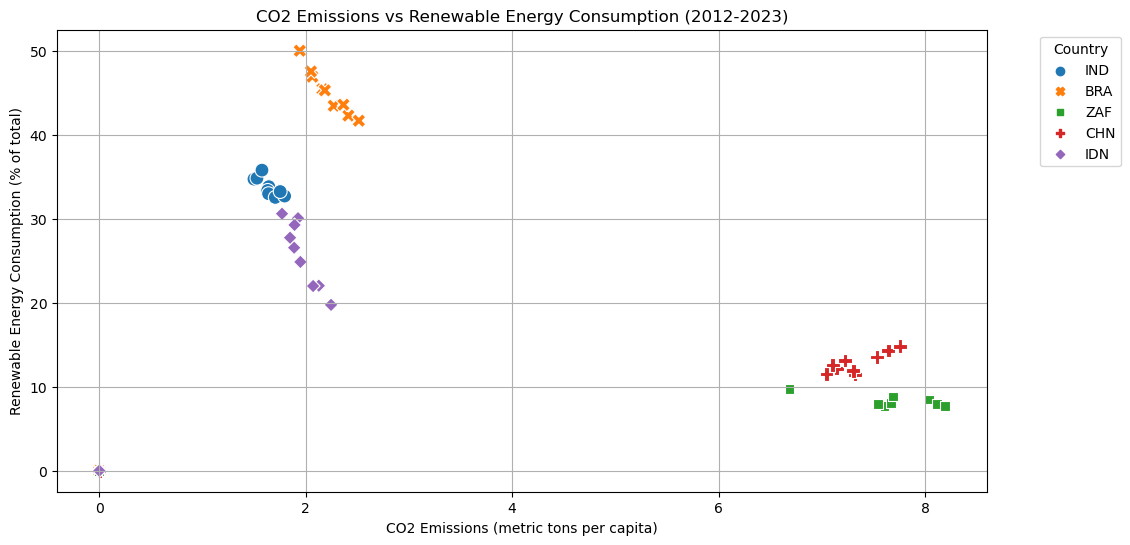

In [20]:
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
comparison_df = compare_co2_with_renewable_energy(table, countries, 'EN.ATM.CO2E.PC', 'EG.FEC.RNEW.ZS', 2012, 2023)
# Plotting the comparison
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x='CO2 Emissions', y='Renewable Energy Consumption', hue='Country', style='Country', s=100)
plt.title('CO2 Emissions vs Renewable Energy Consumption (2012-2023)')
plt.xlabel('CO2 Emissions (metric tons per capita)')
plt.ylabel('Renewable Energy Consumption (% of total)')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

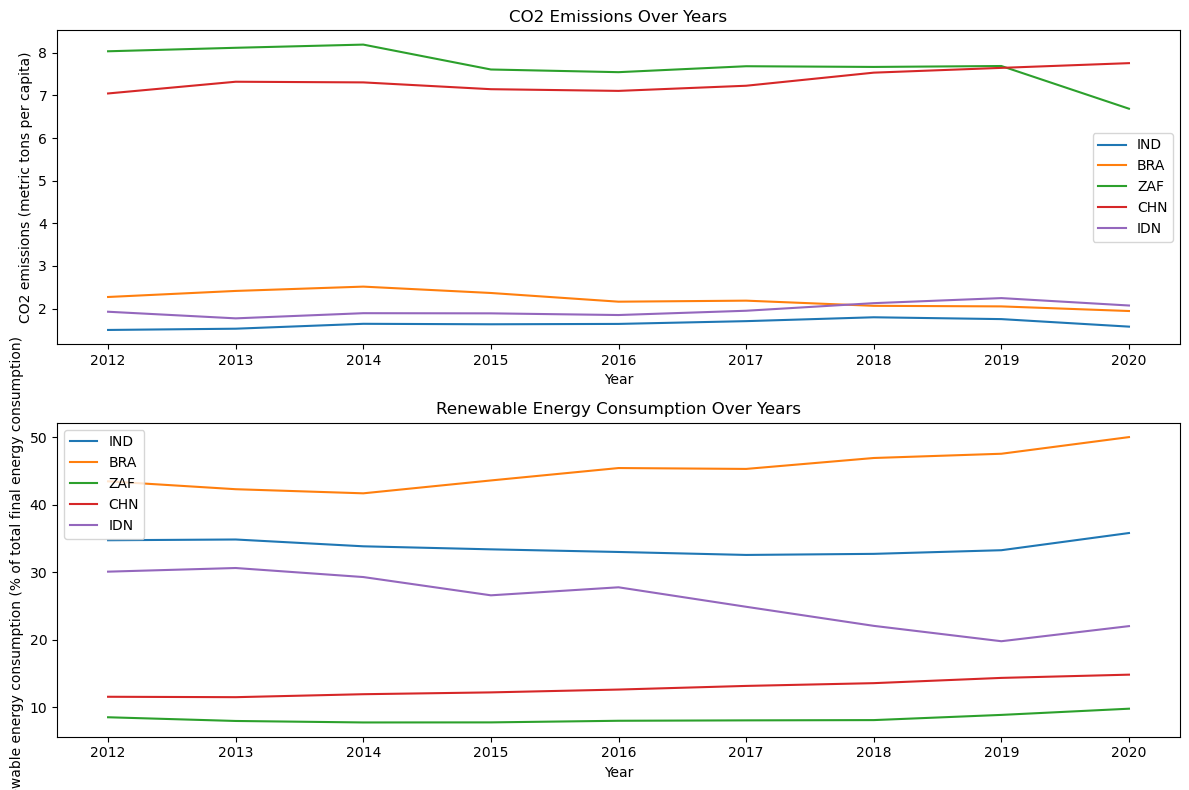

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_co2_with_renewable_energy(table, country_codes, series_code_co2, series_code_renewable, start_year, end_year):
    # Initialize two separate subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    for country_code in country_codes:
        co2_values = []
        renewable_values = []
        years = []

        for year in range(start_year, end_year + 1):
            co2_row_key = create_row_key(country_code, series_code_co2, year)
            renewable_row_key = create_row_key(country_code, series_code_renewable, year)
            co2_row = table.read_row(co2_row_key)
            renewable_row = table.read_row(renewable_row_key)
            
            if co2_row and renewable_row:
                co2_value = get_metric_value(co2_row, 'metrics', series_code_co2)
                renewable_value = get_metric_value(renewable_row, 'metrics', series_code_renewable)
                co2_values.append(co2_value)
                renewable_values.append(renewable_value)
                years.append(year)

        # Create line plots for CO2 emissions
        ax1.plot(years, co2_values, label=country_code)

        # Create line plots for renewable energy consumption
        ax2.plot(years, renewable_values, label=country_code)

    # Configure the first subplot (CO2 emissions)
    ax1.set_title('CO2 Emissions Over Years')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CO2 emissions (metric tons per capita)')
    ax1.legend()

    # Configure the second subplot (Renewable Energy Consumption)
    ax2.set_title('Renewable Energy Consumption Over Years')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Renewable energy consumption (% of total final energy consumption)')
    ax2.legend()

    # Adjust the layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plots
    plt.show()

# Example usage
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
compare_co2_with_renewable_energy(table, countries, 'EN.ATM.CO2E.PC', 'EG.FEC.RNEW.ZS', 2012, 2020)


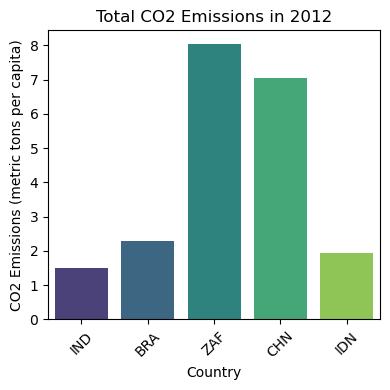

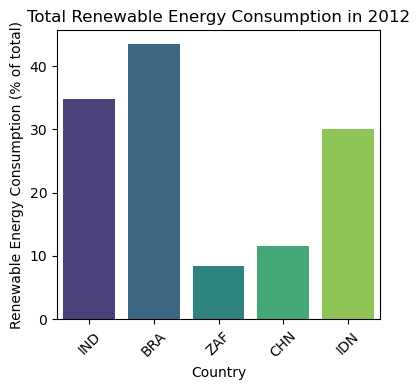

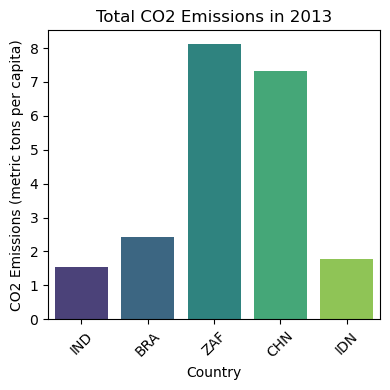

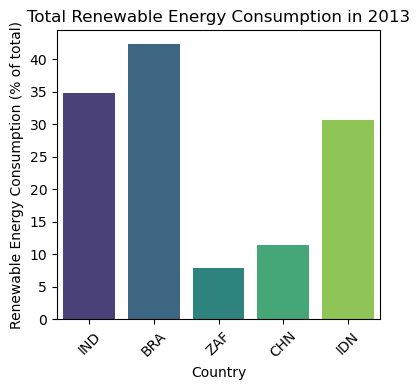

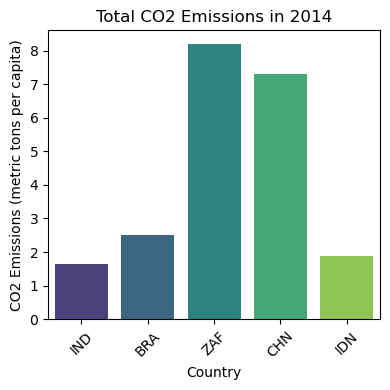

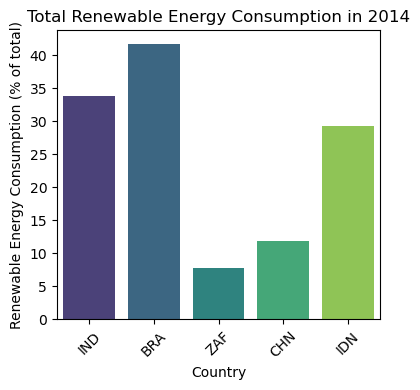

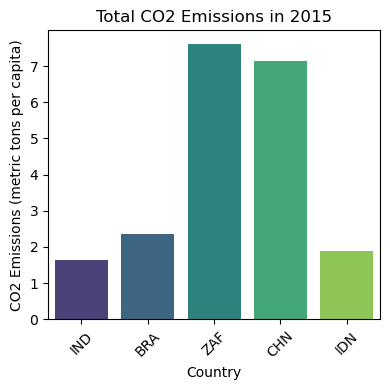

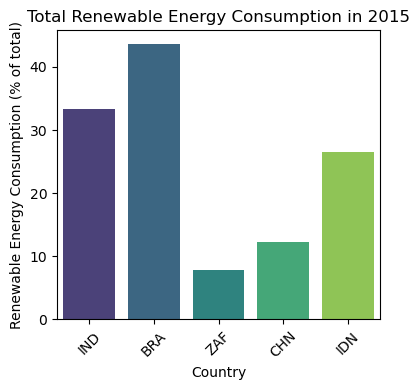

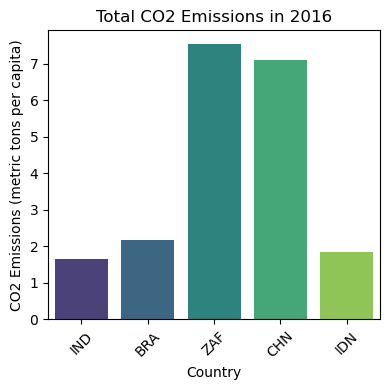

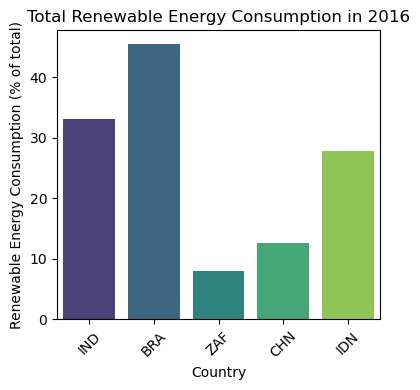

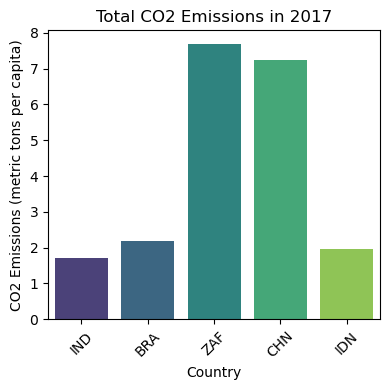

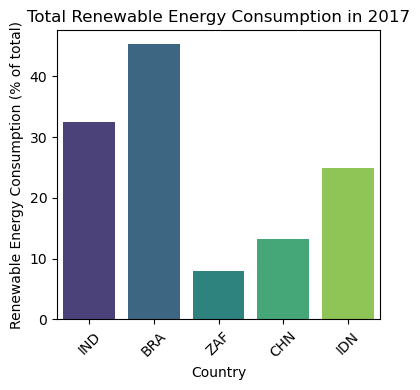

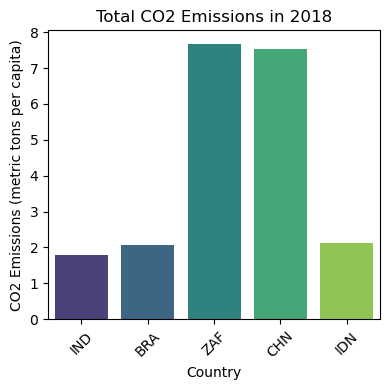

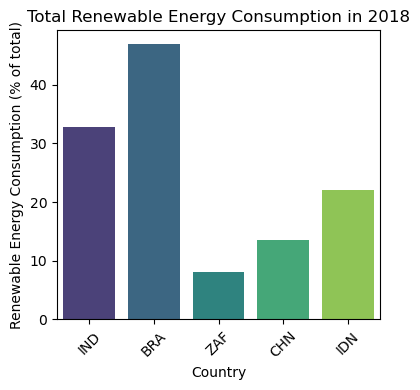

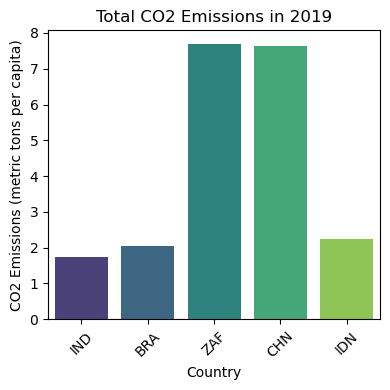

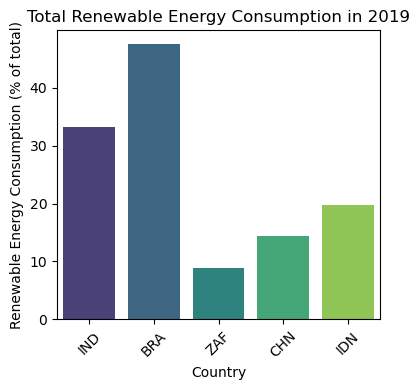

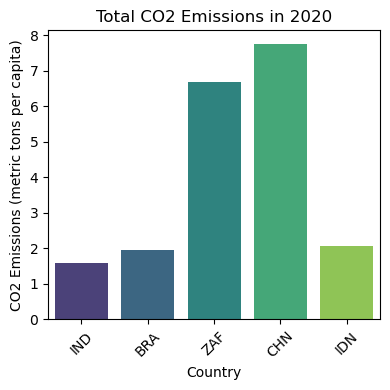

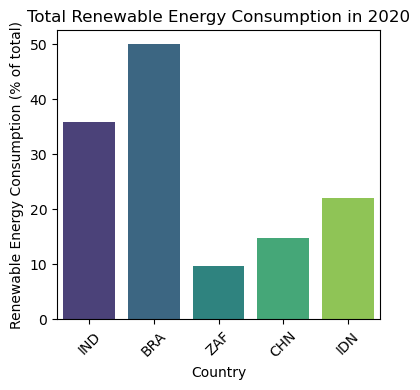

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_co2_with_renewable_energy(table, country_codes, series_code_co2, series_code_renewable, start_year, end_year):
    comparison_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            co2_row_key = create_row_key(country_code, series_code_co2, year)
            renewable_row_key = create_row_key(country_code, series_code_renewable, year)
            co2_row = table.read_row(co2_row_key)
            renewable_row = table.read_row(renewable_row_key)
            if co2_row and renewable_row:
                co2_value = get_metric_value(co2_row, 'metrics', series_code_co2)
                renewable_value = get_metric_value(renewable_row, 'metrics', series_code_renewable)
                comparison_data.append({
                    'Country': country_code,
                    'Year': year,
                    'CO2 Emissions': co2_value,
                    'Renewable Energy Consumption': renewable_value
                })

    comparison_df = pd.DataFrame(comparison_data)

    bar_width = 0.02  
    for year in range(start_year, end_year + 1):
        year_data = comparison_df[comparison_df['Year'] == year]
        plt.figure(figsize=(4, 4))  
        
        # Create bar plots for CO2 emissions
        sns.barplot(data=year_data, x='Country', y='CO2 Emissions', palette='viridis')
        plt.title(f'Total CO2 Emissions in {year}')
        plt.xlabel('Country')
        plt.ylabel('CO2 Emissions (metric tons per capita)')
        plt.xticks(rotation=45)  # Rotate x-axis labels for readability
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(4, 4))  
        
        # Create bar plots for renewable energy consumption
        sns.barplot(data=year_data, x='Country', y='Renewable Energy Consumption', palette='viridis')
        plt.title(f'Total Renewable Energy Consumption in {year}')
        plt.xlabel('Country')
        plt.ylabel('Renewable Energy Consumption (% of total)')
        plt.xticks(rotation=45)  # Rotate x-axis labels for readability
        plt.tight_layout()
        plt.show()


countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
compare_co2_with_renewable_energy(table, countries, 'EN.ATM.CO2E.PC', 'EG.FEC.RNEW.ZS', 2012, 2020)


### Query 3: Analyze Foreign Direct Investment in Renewable Energy

In [21]:
def fdi(table, country_codes, series_code, start_year, end_year):
    fdi_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            row_key = create_row_key(country_code, series_code, str(year))
            row = table.read_row(row_key)
            if row:
                fdi_value = get_metric_value(row, 'metrics', series_code)
                fdi_data.append({
                    'Country': country_code,
                    'Year': year,
                    'Foreign Direct Investment net inflows (% of GDP)': fdi_value
                })
    return pd.DataFrame(fdi_data)

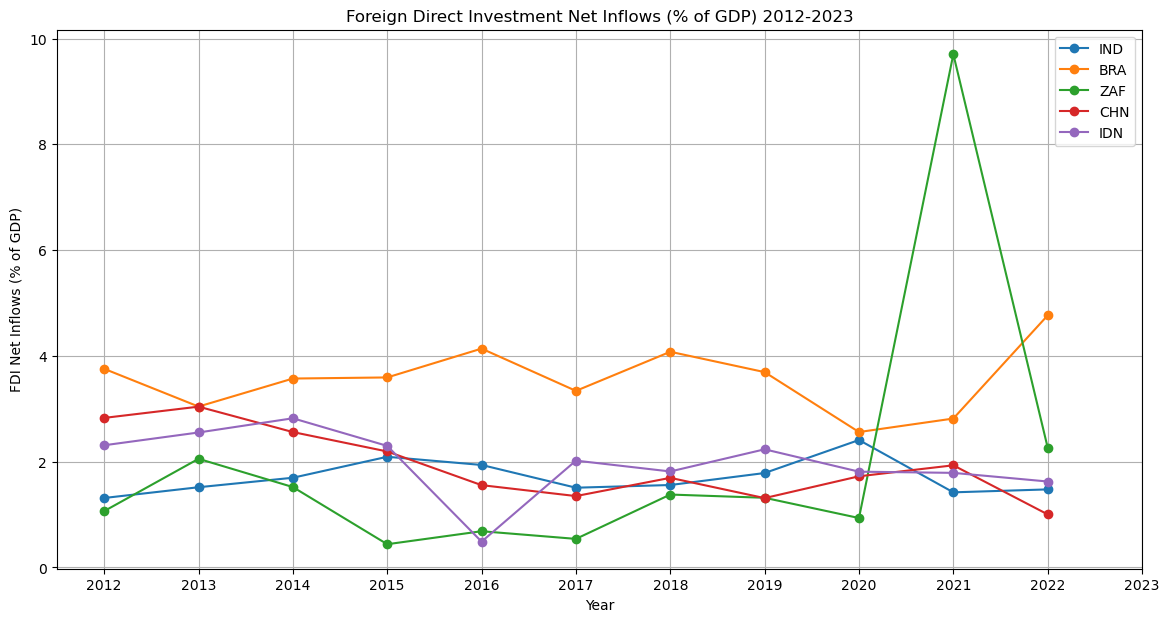

In [28]:
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
fdi_df = fdi(table, countries, 'BX.KLT.DINV.WD.GD.ZS', 2012, 2023)

plt.figure(figsize=(14, 7))

for country in countries:
    country_df = fdi_df[fdi_df['Country'] == country]
    plt.plot(country_df['Year'], country_df['Foreign Direct Investment net inflows (% of GDP)'], marker='o', label=country)

plt.title('Foreign Direct Investment Net Inflows (% of GDP) 2012-2023')
plt.xlabel('Year')
plt.ylabel('FDI Net Inflows (% of GDP)')
plt.xticks(range(2012, 2024))
plt.legend()
plt.grid(True)


plt.show()


### Query 4: Assessing Public-Private Partnerships in Energy

In [23]:
def public_private_partnerships_in_energy(table, country_codes, series_code, start_year, end_year):
    ppp_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            row_key = create_row_key(country_code, series_code, str(year))
            row = table.read_row(row_key)
            if row:
                ppp_value = get_metric_value(row, 'metrics', series_code)
                ppp_data.append({
                    'Country': country_code,
                    'Year': year,
                    'PPP in Energy': ppp_value
                })
    return pd.DataFrame(ppp_data)

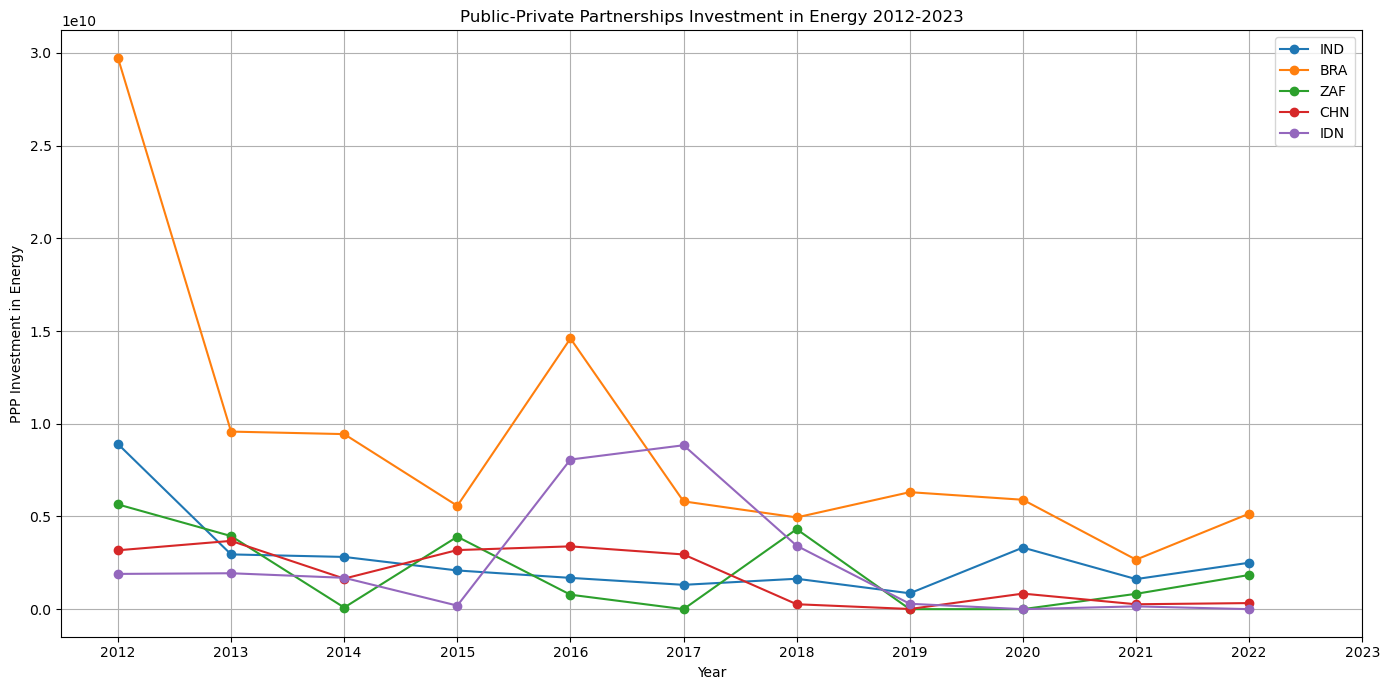

In [24]:
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
ppp_df = public_private_partnerships_in_energy(table, countries, 'IE.PPN.ENGY.CD', 2012, 2023)

# Create a line plot for PPP trends
plt.figure(figsize=(14, 7))

for country in countries:
    country_df = ppp_df[ppp_df['Country'] == country]
    plt.plot(country_df['Year'], country_df['PPP in Energy'], marker='o', label=country)

plt.title('Public-Private Partnerships Investment in Energy 2012-2023')
plt.xlabel('Year')
plt.ylabel('PPP Investment in Energy')
plt.xticks(range(2012, 2024))  
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Query 5: Correlate Education and R&D Ependiture with Renewable Energy Consumption

In [25]:
def correlate_education_and_rd_with_renewable_energy(table, country_codes, education_series_code, rd_series_code, renewable_series_code, start_year, end_year):
    correlation_data = []
    for country_code in country_codes:
        for year in range(start_year, end_year + 1):
            education_row_key = create_row_key(country_code, education_series_code, str(year))
            rd_row_key = create_row_key(country_code, rd_series_code, str(year))
            renewable_row_key = create_row_key(country_code, renewable_series_code, str(year))
            education_row = table.read_row(education_row_key)
            rd_row = table.read_row(rd_row_key)
            renewable_row = table.read_row(renewable_row_key)
            if education_row and rd_row and renewable_row:
                education_value = get_metric_value(education_row, 'metrics', education_series_code)
                rd_value = get_metric_value(rd_row, 'metrics', rd_series_code)
                renewable_value = get_metric_value(renewable_row, 'metrics', renewable_series_code)
                correlation_data.append({
                    'Country': country_code,
                    'Year': year,
                    'Education Expenditure': education_value,
                    'R&D Expenditure': rd_value,
                    'Renewable Energy Consumption': renewable_value
                })
    return pd.DataFrame(correlation_data)

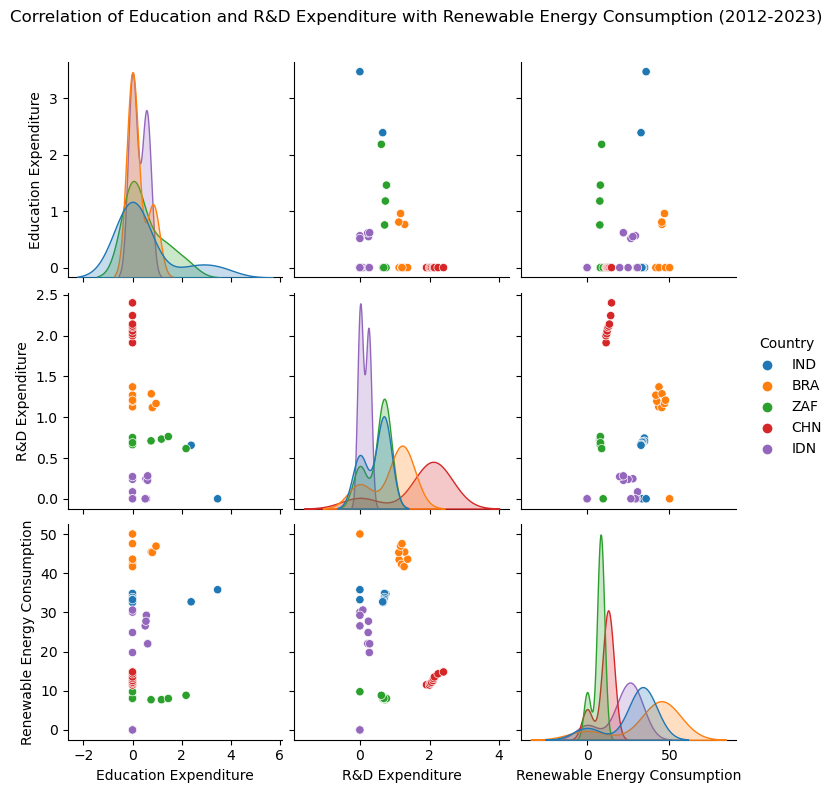

In [27]:
countries = ['IND', 'BRA', 'ZAF', 'CHN', 'IDN']
correlation_df = correlate_education_and_rd_with_renewable_energy(table, countries, 'SE.TER.CUAT.MS.ZS', 'GB.XPD.RSDV.GD.ZS', 'EG.FEC.RNEW.ZS', 2012, 2023)

# Ensure columns are numeric
correlation_df['Education Expenditure'] = pd.to_numeric(correlation_df['Education Expenditure'], errors='coerce')
correlation_df['R&D Expenditure'] = pd.to_numeric(correlation_df['R&D Expenditure'], errors='coerce')
correlation_df['Renewable Energy Consumption'] = pd.to_numeric(correlation_df['Renewable Energy Consumption'], errors='coerce')

# Drop rows with any NaN values
correlation_df.dropna(inplace=True)

# Plotting the pair plot
pair_plot = sns.pairplot(correlation_df, hue='Country', vars=['Education Expenditure', 'R&D Expenditure', 'Renewable Energy Consumption'])
plt.suptitle('Correlation of Education and R&D Expenditure with Renewable Energy Consumption (2012-2023)', y=1.05)
plt.show()